# In Class "Better Model" Development

In [1]:
#using sympy to implement model conditions
import sympy
import numpy
from matplotlib import pyplot
import ipywidgets

%matplotlib inline

In [2]:
sympy.init_printing()

(u_max, u_star, rho_max, 
 rho_star, A, B) = sympy.symbols('u_max u^* rho_max rho^* A B')

In [3]:
#No Traffic at Max Density
eq1 = sympy.Eq(0, u_max * rho_max * (1 - A * rho_max - B * rho_max**2))

#Max flux occurs at rho = rho_star (derivative of F(rho_star) = 0)
eq2 = sympy.Eq(0, u_max * (1 - 2 * A * rho_star - 3 * B * rho_star**2))

#u_star is obtained at rho = rho_star
eq3 = sympy.Eq(u_star, u_max * (1 - A * rho_star - B * rho_star**2))

In [4]:
eq1

In [5]:
eq2

In [6]:
eq3

In [7]:
#Three solutions with three unknowns (A, B, rho_star - u_star is determined via observation)
#Eliminate a B
eq4 = sympy.Eq(eq2.lhs - 3 * eq3.lhs, eq2.rhs - 3 * eq3.rhs)
eq4

In [8]:
eq4.simplify()

In [9]:
eq4.expand()

In [10]:
rho_sol = sympy.solve(eq4, rho_star)[0]
rho_sol

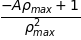

In [11]:
B_sol = sympy.solve(eq1, B)[0]
B_sol

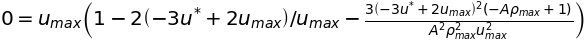

In [12]:
quadA = eq2.subs([(rho_star, rho_sol), (B, B_sol)])
quadA

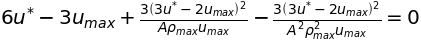

In [13]:
quadA.simplify()

In [14]:
A_sol = sympy.solve(quadA, A)

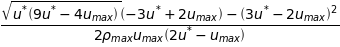

In [15]:
A_sol[0]

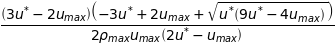

In [16]:
A_sol[1]

In [17]:
#Numerically evaluate given that rho_max = 10.0, u_max = 1.0, u_star = 0.7
A_val_0 = A_sol[0].evalf(subs = {u_star: 0.7, u_max: 1.0, rho_max: 10.0})
A_val_0

In [18]:
A_val_1 = A_sol[1].evalf(subs = {u_star: 0.7, u_max: 1.0, rho_max: 10.0})
A_val_1

In [19]:
A_val = max(A_val_0, A_val_1)
A_val

In [20]:
B_val = B_sol.evalf(subs = {rho_max: 10.0, A: A_val})
B_val

In [21]:
#Turn off LATEX output - great for algebraic expressions obvi
sympy.init_printing(use_latex = False)

In [22]:
print(type(rho_max), type(u_max))

<class 'sympy.core.symbol.Symbol'> <class 'sympy.core.symbol.Symbol'>


In [23]:
#Define some initial parameters bruhhhh
rho_max = 10.0 #maximum density
u_max = 1.0 #maximum velocity
nx = 81 #number of locations on the road
L = 4.0 #road length
dx = L / (nx - 1) #distance between points 
nt = 30 #num of time steps
rho_light = 5.0 #car density at the light

#Define the road locations
x = numpy.linspace(0, L, num = nx)

#Set time-step size based on CFL limit
sigma = 1.0
dt = sigma * dx / u_max #maximum stable step_size

In [57]:
def rho_green_light(x, rho_light):
    """
    Computes the green light initial condition.
    It consists of a shock with a linear distribution behind it.
    
    """
    
    rho = numpy.zeros_like(x)
    mask = numpy.where(x < 2.0)
    rho[mask] = rho_light * x[mask]
    
    return rho

In [58]:
#Define initial traffic density
rho0 = rho_green_light(x, rho_light)

In [59]:
def flux_bm(rho, u_max, A, B):
    """Compute the flux using the 'better' model"""
    
    flux = rho * u_max * (1.0 - A * rho - B * rho**2)
    
    return flux

In [60]:
def flux_qu(rho, rho_max, u_max):
    """Compute the flux using the 'quadratic' model"""
    
    flux = rho * u_max * (1.0 - rho / rho_max)
    
    return flux

In [66]:
def plot(n, x, rho_hist):
    """Plot solution at a given time and compare to initial condition"""
    
    pyplot.figure()
    pyplot.plot(x, rho_hist[0], label = 'Initial')
    pyplot.plot(x, rho_hist[n], label = 'Current')
    pyplot.grid()
    pyplot.legend()
    pyplot.xlim(0.0, 4.0)
    pyplot.ylim(-0.5, 10.0)
    pyplot.xlabel('Length of the road [km]')
    pyplot.ylabel('Density of cars')
    pyplot.show()

In [67]:
rho_hist = [rho0.copy()]

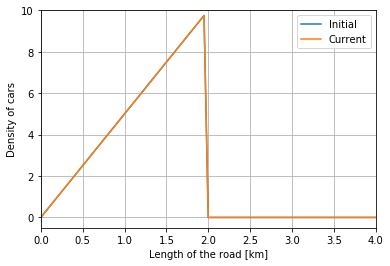

In [68]:
plot(0, x, rho_hist)

In [69]:
def ftbs_bm(rho0, nt, dt, dx, u_max, rho_max, A, B):
    """Solve the density - green light problem using the
    forward time - backward space method with the better 
    flux model"""
    
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        F = flux_bm(rho, u_max, A, B)
        #F = flux_qu(rho, rho_max, u_max)
        rho[1:] = rho[1:] - dt / dx * (F[1:] - F[:-1])
        rho_hist.append(rho.copy())
    
    return rho_hist

In [70]:
def ftbs_qu(rho0, nt, dt, dx, u_max, rho_max, A, B):
    """Solve the density - green light problem using the
    forward time - backward space method with the better 
    flux model"""
    
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        #F = flux_bm(rho, u_max, A, B)
        F = flux_qu(rho, rho_max, u_max)
        rho[1:] = rho[1:] - dt / dx * (F[1:] - F[:-1])
        rho_hist.append(rho.copy())
    
    return rho_hist

In [71]:
rho_hist_bm = ftbs_bm(rho0, nt, dt, dx, u_max, rho_max, A_val, B_val)
rho_hist_qu = ftbs_qu(rho0, nt, dt, dx, u_max, rho_max, A_val, B_val)

C:\Users\bghanman\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in square
  after removing the cwd from sys.path.


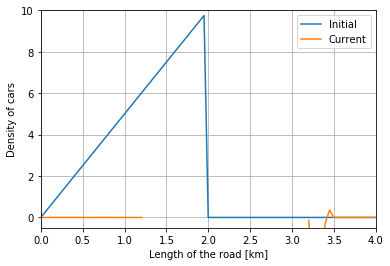

In [72]:
plot(nt, x, rho_hist_bm)

In [73]:
def interactive_plot(x, rho_hist):
    nt = len(rho_hist) - 1
    nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1,
                                    description='Time Step')
    w = ipywidgets.interactive(plot, n=nt_slider,
                              x=ipywidgets.fixed(x),
                              rho_hist=ipywidgets.fixed(rho_hist))
    
    return w

In [74]:
interactive_plot(x, rho_hist_bm)

interactive(children=(IntSlider(value=0, description='Time Step', max=30), Output()), _dom_classes=('widget-in…

In [75]:
interactive_plot(x, rho_hist_qu)

interactive(children=(IntSlider(value=0, description='Time Step', max=30), Output()), _dom_classes=('widget-in…

In [89]:
def lax_friedrichs(rho0, nt, dt, dx, flux, *args):
    """Compute traffic density using the lax_friedrichs method"""
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        F = flux(rho, *args)
        rho[1:-1] = (0.5 * (rho[2:] + rho[:-2]) - 
        0.5 * dt / dx * (F[2:] - F[:-2]))
        rho_hist.append(rho.copy())
    
    return rho_hist

In [90]:
#passing required arguments for the better model
rho_hist_lf = lax_friedrichs(rho0, nt, dt, dx, flux_bm,
                             u_max, A_val, B_val)
rho_hist_lf_qu = lax_friedrichs(rho0, nt, dt, dx, flux_qu,
                             rho_max, u_max)

C:\Users\bghanman\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in square
  after removing the cwd from sys.path.
C:\Users\bghanman\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in add
  import sys


In [92]:
interactive_plot(x, rho_hist_lf)

interactive(children=(IntSlider(value=0, description='Time Step', max=30), Output()), _dom_classes=('widget-in…

In [91]:
interactive_plot(x, rho_hist_lf_qu)

interactive(children=(IntSlider(value=0, description='Time Step', max=30), Output()), _dom_classes=('widget-in…